In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

In [5]:
data = pd.read_csv('US_Accidents_March23.csv')

## Initial Data cleaning

In [7]:
# clean out columns that don't specifically relate to weather or infratructure
drop_columns = ['ID', 'Source', 'Start_Time', 'End_Time', 
                 'End_Lat', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
                 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 
                 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

df = data.drop(drop_columns, axis=1)
df["severe"] = (df['Severity'] >= 3).astype(int)

## Summary Statistics

In [33]:
def weather_analysis(csv_file):  
    """Uses RandomForestClassifier from sklearn to analyze the impact of different weather
    conditions on accident severity.
    
        Parameters:
        - csv_file (str): file containing data with columns as in the US Accidents dataset from Kaggle.

        Returns:
        - sorted_importance (list): list of features and importance sorted by importance
    """
    
    City = pd.read_csv(csv_file)

    City["labels"] = City["Severity"] >= 3   # new column for binary severity labels
    City = City[['labels', 'Temperature(F)', 'Wind_Chill(F)', 'Pressure(in)', 'Visibility(mi)',
        'Wind_Speed(mph)', 'Precipitation(in)', 'Humidity(%)']]

    # get train and test data
    shuffled = City.sample(frac=1, random_state=21)
    groups = np.array_split(shuffled, 3)

    X = groups[0].to_numpy().astype(float)
    X_train, y_train = X[:, 1:], X[:, 0]

    # train a random forest classifier
    forest = RandomForestClassifier(oob_score=True)
    forest.fit(X_train, y_train)
    print(f"\noob score: {forest.oob_score_}")
    sorted_importance = sorted(list(zip(forest.feature_importances_, City.columns[1:-1])))[::-1]
    print(f"\nFeature importance: {sorted_importance}")

    # get accuracy score
    X1 = groups[1].to_numpy().astype(float)
    X_test, y_test = X1[:, 1:], X1[:, 0]
    pred = forest.predict(X_test)
    accuracy = accuracy_score(pred, y_test)
    print(f"\nAccuracy Score: {accuracy}")

    return sorted_importance

In [34]:
# describe data
df.shape
print(df.nunique())

(7728394, 31)

In [9]:
df.head(5)

,Severity,Start_Lat,Start_Lng,Street,City,County,State,Temperature(F),Wind_Chill(F),Humidity(%),...,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,severe
0,3,39.865147,-84.058723,I-70 E,Dayton,Montgomery,OH,36.9,NaN,91.0,...,False,False,False,False,False,False,False,False,Night,1
1,2,39.928059,-82.831184,Brice Rd,Reynoldsburg,Franklin,OH,37.9,NaN,100.0,...,False,False,False,False,False,False,False,False,Night,0
2,2,39.063148,-84.032608,State Route 32,Williamsburg,Clermont,OH,36.0,33.3,100.0,...,False,False,False,False,False,False,True,False,Night,0
3,3,39.747753,-84.205582,I-75 S,Dayton,Montgomery,OH,35.1,31.0,96.0,...,False,False,False,False,False,False,False,False,Night,1
4,2,39.627781,-84.188354,Miamisburg Centerville Rd,Dayton,Montgomery,OH,36.0,33.3,89.0,...,False,False,False,False,False,False,True,False,Day,0


In [11]:
df.nunique()

Severity                   4
Start_Lat            2428358
Start_Lng            2482533
Street                336306
City                   13678
County                  1871
State                     49
Temperature(F)           860
Wind_Chill(F)           1001
Humidity(%)              100
Pressure(in)            1144
Visibility(mi)            92
Wind_Direction            24
Wind_Speed(mph)          184
Precipitation(in)        299
Weather_Condition        144
Amenity                    2
Bump                       2
Crossing                   2
Give_Way                   2
Junction                   2
No_Exit                    2
Railway                    2
Roundabout                 2
Station                    2
Stop                       2
Traffic_Calming            2
Traffic_Signal             2
Turning_Loop               1
Sunrise_Sunset             2
severe                     2
dtype: int64

In [10]:
df.isna().sum()

Severity                   0
Start_Lat                  0
Start_Lng                  0
Street                 10869
City                     253
County                     0
State                      0
Temperature(F)        163853
Wind_Chill(F)        1999019
Humidity(%)           174144
Pressure(in)          140679
Visibility(mi)        177098
Wind_Direction        175206
Wind_Speed(mph)       571233
Precipitation(in)    2203586
Weather_Condition     173459
Amenity                    0
Bump                       0
Crossing                   0
Give_Way                   0
Junction                   0
No_Exit                    0
Railway                    0
Roundabout                 0
Station                    0
Stop                       0
Traffic_Calming            0
Traffic_Signal             0
Turning_Loop               0
Sunrise_Sunset         23246
severe                     0
dtype: int64

## Identify Cities

In [6]:
def identify_cities(
    df,
    min_samples=1000,
):
    """
    Paramters:
        df: our cleaned dataset with binary severity
        min_samples: use cities large enough to build a classifier
    Returns:
        most_dangerous city: highest p_map
        least_dangerous city: lowest p_map
    """
    df = df.copy()

    # df with each city, total accidents, total severe
    props_df = df.groupby('City').agg(
        k=('severe', 'sum'),
        n=('severe', 'size')
    )

    # only use cities with more than 1000 
    big_cities_df = props_df[props_df['n'] >= min_samples].copy()
    small_cities_df = props_df[props_df['n'] < min_samples].copy()

    # build a beta prior distribution 

    # prop severe accidents over all data not used
    total_k = small_cities_df['k'].sum()
    total_n = small_cities_df['n'].sum()
    mu_hat = total_k / total_n

    # parameters for beta prior:
    # beta with mean from small cities and scaled by 1000
    alpha_prior = mu_hat * 1000
    beta_prior= (1 - mu_hat) * 1000

    # parameters for beta posterior Vol 3 example 4.63
    big_cities_df['alpha_post'] = alpha_prior + big_cities_df['k']
    big_cities_df['beta_post'] = beta_prior + big_cities_df['n'] - big_cities_df['k']

    # MAP estimate for each city: Vol 3 Eqn 4.27
    big_cities_df['p_map'] = (
        (big_cities_df['alpha_post'] - 1) /
        (big_cities_df['alpha_post'] + big_cities_df['beta_post'] - 2)
    )

    # extract cities with greateset and smallest estimated prop severe accidents
    most_dangerous = big_cities_df["p_map"].idxmax()
    least_dangerous = big_cities_df["p_map"].idxmin()

    return most_dangerous, least_dangerous

print(identify_cities(df))

('Saint Louis', 'Fresno')


#### Safe City: Fresno

Text(0.5, 1.0, 'Accidents in Fresno, Least Dangerous City')

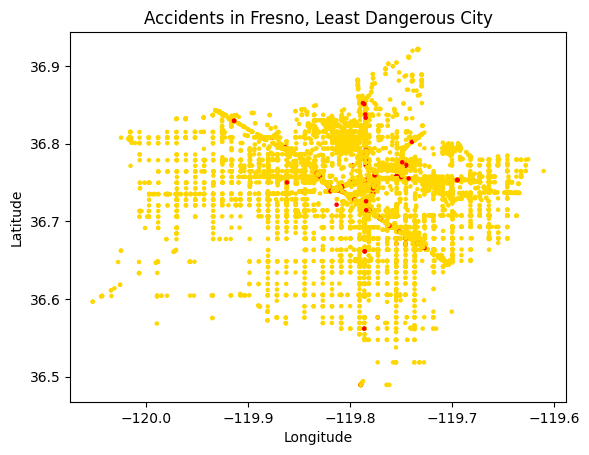

In [ ]:
# get small city data frame
fresno = df.groupby("City").get_group("Fresno")

# leave out data points too far away, can be adjusted for othe cities
fresno = fresno[fresno["Start_Lng"] <= -110].copy()
lat = fresno["Start_Lat"]
long = fresno["Start_Lng"]

# color by severity only severe and non severe
color_map = {1: "gold", 2:"gold", 3:"red", 4:"red"}
colors = fresno['Severity'].map(color_map)

# plot formatting
plt.scatter(long, lat, c=colors, s=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Accidents in Fresno, Least Dangerous City")

#### Dangerous City: St Louis

Text(0.5, 1.0, 'Accidents in St Louis, Most Dangerous City')

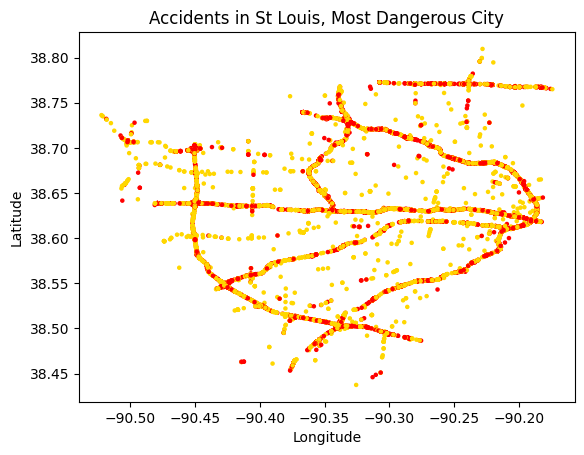

In [8]:
# get smaller df for st louis
stlouis = df.groupby("City").get_group("Saint Louis")
stlouis = stlouis[stlouis["Start_Lng"] <= -89].copy()   # cut out cities too far away
lat = stlouis["Start_Lat"]
long = stlouis["Start_Lng"]

# color points by severity
color_map = {1: "gold", 2:"gold", 3:"red", 4:"red"}
colors = stlouis['Severity'].map(color_map)

# plor formatting
plt.scatter(long, lat, c=colors, s=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Accidents in St Louis, Most Dangerous City")

## Random Forest Classifiers

### Weather

In [9]:
# weather analysis for Fresno
print("Fresno:\n")
sorted_importance_fresno = weather_analysis("Fresno_accidents.csv")

# weather analysis for St. Louis
print("\n\nSt. Louis:\n")
sorted_importance_stlouis = weather_analysis("StLouis_accidents.csv")


oob score: 0.9858195211786372

Feature importance: [(np.float64(0.20990789504445717), 'Pressure(in)'), (np.float64(0.17014403970989972), 'Temperature(F)'), (np.float64(0.13954437112385287), 'Wind_Chill(F)'), (np.float64(0.12784536391897752), 'Wind_Speed(mph)'), (np.float64(0.07287734073499291), 'Precipitation(in)'), (np.float64(0.06789174863214026), 'Visibility(mi)')]

Accuracy Score: 0.9878453038674033


St. Louis:


oob score: 0.8122807017543859

Feature importance: [(np.float64(0.2316202368218237), 'Pressure(in)'), (np.float64(0.18595338941221773), 'Temperature(F)'), (np.float64(0.1690773220582313), 'Wind_Chill(F)'), (np.float64(0.15189167431307743), 'Wind_Speed(mph)'), (np.float64(0.039138711997400155), 'Visibility(mi)'), (np.float64(0.01833081112225699), 'Precipitation(in)')]

Accuracy Score: 0.7873462214411248


/usr/local/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


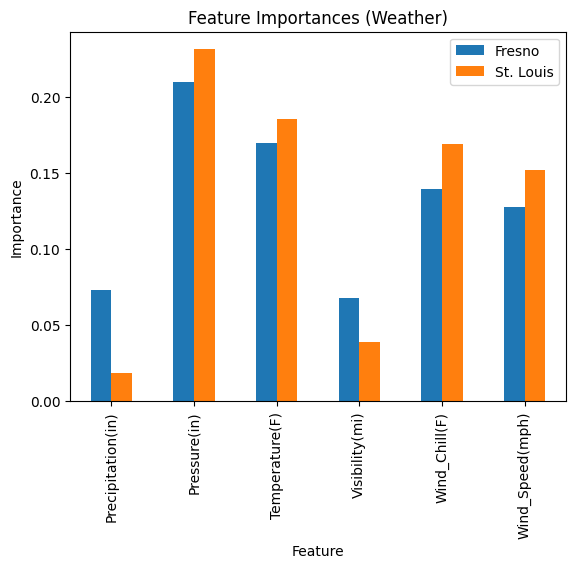

In [35]:
# plot both side by side in a bar plot
importances1 = pd.Series([i for i, _ in sorted_importance_fresno], index=[j for _, j in sorted_importance_fresno])
importances2 = pd.Series([i for i, _ in sorted_importance_stlouis], index=[j for _, j in sorted_importance_stlouis])
overall = pd.DataFrame({"Fresno": importances1, "St. Louis": importances2})

ax = overall.plot(kind='bar')
plt.legend()
plt.title("Feature Importances (Weather)")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.savefig("weather_importances.png")
plt.show()

### Infrastructure

In [36]:
def infrastructure_analysis(csv_file):
    """Use RandomForestClassifier to analyze the impact of infrastructure features on
    accident severity.
        
        Parameters:
        - csv_file (str): filepath to csv file with columns as in kaggle US Accident Data

        Returns:
        - sorted_importance (list): list of features and importance sorted by importance
    """
    City = pd.read_csv("Fresno_accidents.csv")
    City['labels'] = City['Severity'] >= 3   # convert to binary severity labels
    City = City[["labels", 'Amenity', 'Crossing', 'Give_Way',
        'Junction', 'No_Exit', 'Railway', 'Station', 'Stop',
        'Traffic_Signal']]

    # get test and train data
    shuffled = City.sample(frac=1)
    groups = np.array_split(shuffled, 3)

    X = groups[0].to_numpy().astype(float)
    X_train, y_train = X[:, 1:], X[:, 0]

    # train a model
    forest = RandomForestClassifier(oob_score=True)
    forest.fit(X_train, y_train)

    print(f"\noob score: {forest.oob_score_}")
    sorted_importance = sorted(list(zip(forest.feature_importances_, list(City.columns[1:]))))[::-1]
    print(f"\nFeature importance: {sorted_importance}")

    # test it
    test = groups[1].to_numpy().astype(float)
    X_test, y_test = test[:, 1:], test[:, 0]
    pred = forest.predict(X_test)
    score = accuracy_score(y_test, pred)
    print(f"\nAccuracy Score: {score}\n")

    return sorted_importance


In [37]:
# infrastructure features analysis for Fresno
print("Fresno:\n")
sorted_importance_fresno1 = infrastructure_analysis("Fresno_accidents.csv")

# infrastructure features analysis for St. Louis
print("\n\nSt. Louis:\n")
sorted_importance_stlouis1 = infrastructure_analysis("StLouis_accidents.csv")

Fresno:



/usr/local/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



oob score: 0.9880294659300184

Feature importance: [(np.float64(0.5097576700950592), 'Crossing'), (np.float64(0.3004038521891383), 'Traffic_Signal'), (np.float64(0.10398174921893767), 'Railway'), (np.float64(0.06124329404363322), 'Junction'), (np.float64(0.01855867116135069), 'Stop'), (np.float64(0.0025362485088393813), 'Station'), (np.float64(0.002052936199958283), 'No_Exit'), (np.float64(0.0014655785830833665), 'Amenity'), (np.float64(0.0), 'Give_Way')]

Accuracy Score: 0.9882136279926336



St. Louis:



/usr/local/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



oob score: 0.9860036832412523

Feature importance: [(np.float64(0.46060914549029436), 'Junction'), (np.float64(0.2153993080999368), 'Traffic_Signal'), (np.float64(0.1861814771865804), 'Crossing'), (np.float64(0.07515969146509953), 'Railway'), (np.float64(0.04567079320286347), 'Stop'), (np.float64(0.007379404484890297), 'No_Exit'), (np.float64(0.007257423901668817), 'Station'), (np.float64(0.0023427561686663635), 'Amenity'), (np.float64(0.0), 'Give_Way')]

Accuracy Score: 0.989134438305709



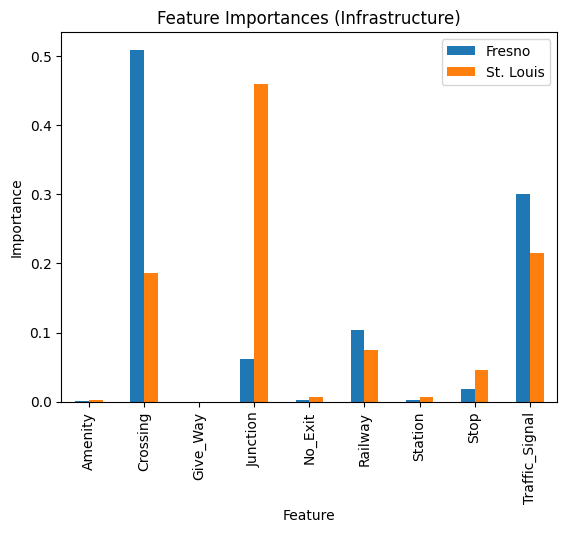

In [38]:
# plots for importances
importances1 = pd.Series([i for i, _ in sorted_importance_fresno1], index=[j for _, j in sorted_importance_fresno1])
importances2 = pd.Series([i for i, _ in sorted_importance_stlouis1], index=[j for _, j in sorted_importance_stlouis1])
overall = pd.DataFrame({"Fresno": importances1, "St. Louis": importances2})

ax = overall.plot(kind='bar')
plt.legend()
plt.title("Feature Importances (Infrastructure)")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.savefig("infrastructure_importances.png")
plt.show()
